[Inhaltsverzeichnis](../AP4.ipynb) | [ < zurück ](wohin?)|  [ > next](wohin?)

## 4.3.1  Szenarien stündlich aufgelöst




FLUCCOplus Setup

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

In [2]:
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [3]:
%matplotlib inline
from FLUCCOplus.notebooks import *


FLUCCOplus.config  loaded!
FLUCCOplus.notebooks loaded!


### Auswahl der Inputs:
* Szenario Name
* zugrundeliegende Zeitreihe


In [4]:
import FLUCCOplus.scenarios as scens

In [5]:
sc = scens.all()
sc

C:\Users\Simon Schneider\anaconda\envs\FLUCCOplus\lib\site-packages\openpyxl\worksheet\_reader.py:308: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\Simon Schneider\anaconda\envs\FLUCCOplus\lib\site-packages\openpyxl\worksheet\_reader.py:308: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


,Jahr,Strombedarf,Mismatch,Importe,Stromproduktion,Wasserkraft,Pumpspeicher,Laufkraft,Windkraft,Photovoltaik,Volatile EE,Nicht-Volatile,RES0,RES1,RES2
Szenario,,,,,,,,,,,,,,,
EM2018,2018,63492.515635,2187.515731,10245.652209,51059.347696,34112.824396,4101.310328,30011.514345,6396.088567,1420.631225,37828.234137,13231.113558,25664.281498,21562.971169,8331.857611
EM2019,2019,59516.148650,2160.129895,3166.423864,54189.594891,34720.379444,3530.617505,31189.761940,7884.167853,1325.057050,40398.986843,13790.608048,19117.161807,15586.544302,1795.936255
E-Control 2019,2019,76588.772116,0.000000,3128.580654,73459.947109,44186.968185,14272.390724,29914.577462,7419.994658,911.999343,38246.571462,20940.984922,0.000000,0.000000,0.000000
Energie und Klimazukunft 2030 (Veigl17),2030,78293.742765,-3799.696328,0.000000,82093.439093,43055.559000,13777.778880,29277.780120,11944.445400,12777.778800,54000.004320,28093.434773,24293.738445,10515.959565,-17577.475208
Erneuerbare Energie 2030 (UBA16),2030,73194.450300,0.000000,-14138.890020,87333.340320,42722.225640,13671.112205,29051.113435,17416.668060,14833.334520,61301.116015,26032.224305,11893.334285,-1777.777920,-27810.002225
WEM 2030 (UBA17),2030,75945.561631,0.000000,2777.778000,73167.783631,43599.447932,13951.823338,29647.624594,7170.278351,9090.000727,45907.903673,27259.879959,30037.657959,16085.834620,-11174.045338
Transition 2030 (UBA17),2030,78613.895178,0.000000,-4444.444800,83058.339978,42133.336704,13482.667745,28650.668959,15456.112348,10740.000859,54846.782166,28211.557812,23767.113012,10284.445267,-17927.112545
Energie und Klimazukunft 2050 (Veigl17),2050,83793.303240,-27697.786393,0.000000,111491.089633,43055.559000,13777.778880,29277.780120,20000.001600,32777.780400,82055.562120,29435.527513,1737.741120,-12040.037760,-41475.565273
Erneuerbare Energie 2050 (UBA16),2050,78722.228520,0.000000,-19722.223800,98444.452320,45277.781400,14488.890048,30788.891352,21083.335020,23555.557440,75427.783812,23016.668508,3294.444708,-11194.445340,-34211.113848


In [6]:
scenario = sc[sc.index=="100% Erneuerbare Deckung 2050 inkl Methan (FLUCCO+)"]

In [7]:
import FLUCCOplus.electricitymap as elmap

<AxesSubplot:xlabel='datetime'>

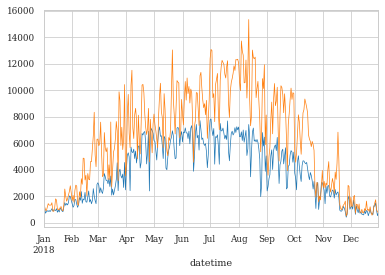

In [64]:
# get solar
pv_prod = elmap.get(year=2018,
               column="power_production_solar_avg",
               set_name="PV [MW]")

pv_cons = elmap.get(year=2018,
               column="power_consumption_solar_avg",
               set_name="PV [MW]")
pv_prod.resample("D").sum().plot()
pv_cons.resample("D").sum().plot()

(425112.0, 425256.0)

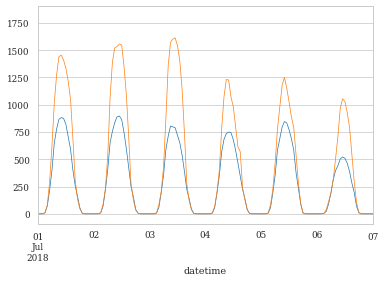

In [66]:
fig, ax = plt.subplots(1,1)
pv_prod.plot(ax=ax)
pv_cons.plot(ax=ax)
ax.set_xlim("07-01-2018", "07-07-2018")

In [45]:
# apply transform
import FLUCCOplus.transform as traffo



In [ ]:
# scale to fit targetsum

# get load
# apply transform
#     ecars (non dsm)
#
# scale to fit targetsum

# em scenario residual load report
